# Isolation Forest Test
This notebook shows how to run Isolation Forest test.

## Import libraries

In [1]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Importing IsolationForest module
from sklearn.ensemble import IsolationForest

#Importing Line2D for marking legend in graph
from matplotlib.lines import Line2D

#Just to filter out warnings- Well I hate warnings popping on the screen 
import warnings
warnings.filterwarnings("ignore")

#We set the seed for random, so we generate same results whenever we run
np.random.seed(0)

### Generate outliers dataset

In [2]:
#Now we will generate datasets 

#Generating a normally distributed data set for training
X = 0.3 * np.random.randn(100, 2)
X_train_normal = np.r_[X + 2, X - 2]

#Generating outliers for training
X_train_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

#Generating a normally distributed dataset for testing
X = 0.3 * np.random.randn(20, 2)
X_test_normal = np.r_[X + 2, X - 2]

#Generating outliers for testing
X_test_outliers = np.random.uniform(low=-4, high=4, size=(10, 2))

### Visulize data

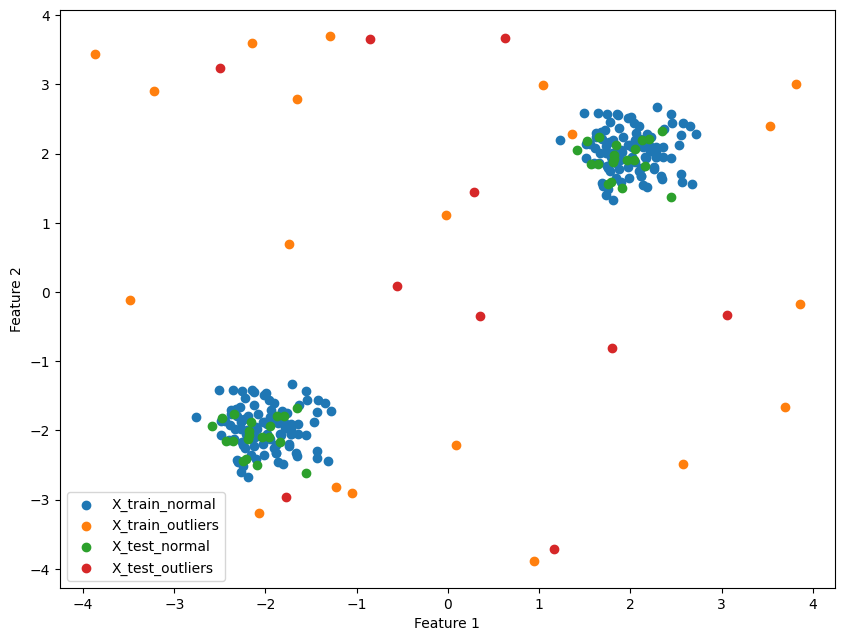

In [3]:

#Plotting and visualising the data points
plt.figure(figsize=(10,7.5))
plt.scatter(X_train_normal[:,0],X_train_normal[:,1],label='X_train_normal')
plt.scatter(X_train_outliers[:,0],X_train_outliers[:,1],label='X_train_outliers')
plt.scatter(X_test_normal[:,0],X_test_normal[:,1],label='X_test_normal')
plt.scatter(X_test_outliers[:,0],X_test_outliers[:,1],label='X_test_outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

### Concate Normal and outliers data

In [4]:
#Now we will append the normal points and outliers- train and test separately
X_train=np.append(X_train_normal,X_train_outliers,axis=0)
# X_train = np.concatenate([X_train,X_train],axis=1)

X_test=np.append(X_test_normal,X_test_outliers,axis=0)
# X_test = np.concatenate([X_test,X_test],axis=1)


### Training with isolation forest algorithm


In [5]:
#Training with isolation forest algorithm
clf = IsolationForest(random_state=0, contamination=0.1)
clf.fit(X_train)

#Now we predict the anomaly state for data
y_train=clf.predict(X_train)
y_test=clf.predict(X_test)  

### Prediction output

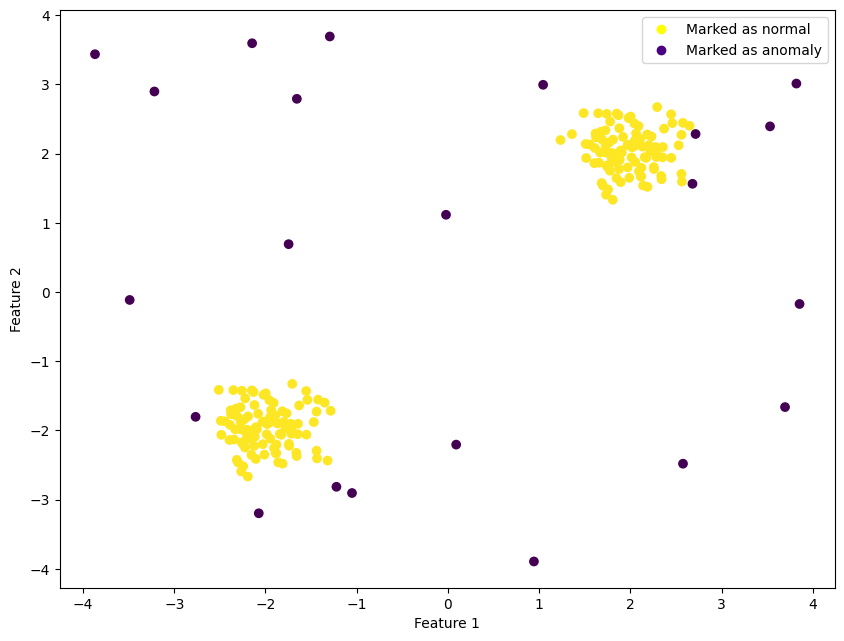

In [6]:
#Now we will plot and visualize how good our algorithm works for training data
#y_train(the state) will mark the colors accordingly
plt.figure(figsize=(10,7.5))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

 
#This is to set the legend appropriately
legend_elements = [Line2D([], [], marker='o', color='yellow', label='Marked as normal',linestyle='None'),
                   Line2D([], [], marker='o', color='indigo', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)

In [7]:
import validmind as vm


vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  project = "clhsvn7va0000kgrl0nwybdff"
)

2023-06-23 16:05:05,462 - INFO - api_client - Connected to ValidMind. Project: Customer Churn Model dev - Initial Validation (clhsvn7va0000kgrl0nwybdff)


In [8]:
vm_data = pd.DataFrame(X_train)
vm_dataset = vm.init_dataset(
    dataset=vm_data,
    type="generic",
)
type(vm_dataset.raw_dataset)


2023-06-23 16:05:05,472 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-23 16:05:05,472 - INFO - dataset - Inferring dataset types...


pandas.core.frame.DataFrame

In [9]:
from dataclasses import dataclass
from validmind.vm_models import ThresholdTest
from sklearn import metrics

from validmind.vm_models import Figure, ThresholdTest
#Importing IsolationForest module
from sklearn.ensemble import IsolationForest
#Importing Line2D for marking legend in graph
from matplotlib.lines import Line2D
import seaborn as sns
import itertools

from validmind.vm_models.metric import Metric


@dataclass
class MyIsolationForest(Metric):
    """
    Isolation Forest.
    This class implements the Isolation Forest algorithm for anomaly detection.
    Attributes:
        name (str): The name of the Isolation Forest.
        default_params (dict): The default parameters for the Isolation Forest.
        required_context (list): The required context for running the Isolation Forest.

    Methods:
        description(): Returns the description of the Isolation Forest.
        run(): Runs the Isolation Forest algorithm.
    """

    name = "isolation_forest"
    default_params = {"random_state": 0,
                      "contamination" : 0.1,
                      "features_columns": None}    
    required_context = ["dataset"]

    def description(self):
        return """
        The Isolation Forest test is an algorithm used for anomaly detection in datasets. It is based
        on the concept of isolating anomalies rather than identifying normal data points. The test builds an ensemble
        of isolation trees, which are binary trees created by randomly selecting features and splitting the data based
        on random thresholds.

        The main idea behind the Isolation Forest test is that anomalies are likely to be isolated quickly in these trees
        compared to normal instances. Anomalies are expected to have shorter average path lengths in the trees,
        as they are different from the majority of the data points.

        It's important to note that the Isolation Forest test assumes anomalies are less frequent and have different properties
        compared to normal instances. However, it may not be as effective in detecting anomalies that are close to each other
        or in datasets where anomalies are more prevalent."""

    def run(self):

        if self.params["features_columns"] is None:
            features_list = self.dataset.get_features_columns()
        else:
            features_list = self.params["features_columns"]

        # Check if all elements from features_list are present in the feature columns
        all_present = all(
            elem in self.dataset.get_features_columns() for elem in features_list
        )
        if not all_present:
            raise ValueError(
                "The list of feature columns provided do not match with "
                + "training dataset feature columns"
            )
        
        dataset = self.dataset.df

        # Training with isolation forest algorithm
        clf = IsolationForest(random_state=self.params["random_state"], contamination=self.params["contamination"])
        clf.fit(dataset)
        y_pred = clf.predict(dataset)
        
        # test passes if there aren't any outliers
        passed = not any(y_pred == -1)
        test_figures = []
        combination_pairs = list(itertools.combinations(features_list, 2))
        for feature1, feature2 in combination_pairs:
            fig = plt.figure(figsize=(10,7.5))
            ax = sns.scatterplot(data=dataset, x=feature1, y=feature2, hue=y_pred, palette="bright")
            handles, labels  =  ax.get_legend_handles_labels()
            labels = list(map(lambda x: x.replace('-1', 'Outliers'), labels))
            labels = list(map(lambda x: x.replace('1', 'Inliers'), labels))
            ax.legend(handles, labels)
            # Do this if you want to prevent the figure from being displayed
            plt.close("all")

            test_figures.append(
                Figure(
                for_object=self,
                key=f"{self.name}:{feature1}_{feature2}",
                figure=fig,
                )
            )

        return self.cache_results(figures=test_figures)


In [10]:
from validmind.vm_models.test_context import TestContext
from validmind.tests.data_validation.IsolationForestOutliers import IsolationForestOutliers
test_context = TestContext(dataset=vm_dataset)
ws_diagnostic = IsolationForestOutliers(test_context)
ws_diagnostic.run()
ws_diagnostic.result.show()